In [1]:
!wget https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/tripadvisor_reviews.tsv
# Se lee con el comando dataset =pd.read_csv("tripadvisor_reviews.tsv", sep="\t")
# Recordar descargar los modelos de spacy y nltk necesarios para la resolución del ejercicio

--2021-04-18 17:10:16--  https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/tripadvisor_reviews.tsv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/tripadvisor_reviews.tsv [following]
--2021-04-18 17:10:16--  https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/tripadvisor_reviews.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14925041 (14M) [text/plain]
Saving to: ‘tripadvisor_reviews.tsv’

tripadvisor_reviews 100%[===================>]  14.23M  29.3MB/s    in 0.5s    

2021-04-18 17:10:17 (29.3 MB/s) - ‘tripadv

# Ejercicio 2 (35%)

El objetivo de este ejercicio es comprobar los conocimientos adquiridos por el alumno en temas relacionados a las transformación de textos utilizando la técnica de TFIDF.

- **Apartado 1**: Preprocesar los textos del corpus con las funciones de preprocesado creadas en el ejercicio 1 (quitar palabras vacías, quitar símbolos de puntuación, lematizar con spacy) (20%)

- **Apartado 2**: Utilizar la función de scikit-learn para realizar la transformación a TF-IDF del texto considerando que:
    - Se consideren unigramas, bigramas y trigramas (20%)
    - No se tengan en cuenta los elementos que aparezcan en menos del 5% de los textos (30%)
    - Se utilice el tokenizador incorporado en Scikit-Learn. (10%)
    - Haya un máximo de 200 características. (10%)


> Nota: Como se dije en clase, recordar los valores por defecto de la función. No es una buena práctica duplicar las tareas de preparación de textos. En este ejercicio se está pidiendo realizar el proceso de limpieza **antes** de introducir la cadena de caracteres a la función de scikit-learn, por lo que esta función no debería re-hacer tareas como quitar stopwords, por ejemplo. (la selección correcta de valores de las variables es el último 10% de la valoración del ejercicio).

> Además, recordar una vez más la necesidad de comentar correctamente el ejercicio para obtener la máxima calificación (tengo que saber si teneis claro el proceso que estais llevando a cabo!)


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import sys  
!{sys.executable} -m pip install contractions #Librería de python que entiende las contracciones como don't 

!pip install spacy
!python -m spacy download es_core_news_sm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 
import contractions 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
     |████████████████████████████████| 286kB 4.2MB/s 
     |████████████████████████████████| 327kB 7.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85392 sha256=f782e8fc75c0f6b8a40ad5f05abb8a29c1762d16ce4d5174d35e463075f7edba
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 16.2MB 5.5MB/s 
  Created wheel for es-core-news-s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
dataset =pd.read_csv("tripadvisor_reviews.tsv", sep="\t")
dataset

,Review,positive
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,0
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",1
20487,great location price view hotel great quick pl...,1
20488,"ok just looks nice modern outside, desk staff ...",0
20489,hotel theft ruined vacation hotel opened sept ...,0


--------------------------------------------------------------------------

**Apartado 1:** Información básica sobre el corpus: Número de documentos,
número de documentos duplicados, número de elementos en cada clase.
(10%)


In [4]:
# Número de documentos
print("Tenemos un conjunto de {} documentos".format(len(dataset)))

Tenemos un conjunto de 20491 documentos


In [5]:
# Número de documentos duplicado
print("Existen {} noticias duplicadas".format(np.sum(dataset.duplicated(subset=["Review"]))))

Existen 0 noticias duplicadas


In [6]:
# Nulos
print("Hay {} valores vacíos en las reviews y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las reviews y 0 valores vacíos en las etiquetas en los datos


In [7]:
# Número de elementos en cada clase
dataset["positive"].value_counts()

1    15093
0     5398
Name: positive, dtype: int64

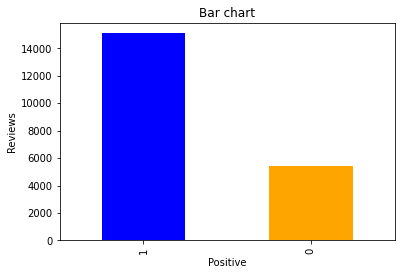

In [8]:
ax, fig = plt.subplots()
etiquetas = dataset.positive.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.ylabel('Reviews')
plt.xlabel('Positive')
plt.show()

Por tanto, estamos ante un dataset con 20491 reviews únicas de las cuáles 15093 son positivas y 5398 son negativas.

--------------------------------------------------------------------------

**Apartado 2:** Diseñar funciones para la normalización de los textos:

o Quitar palabras vacías. (10%)

o Quitar símbolos de puntuación. (10%)

o Lematización con Spacy. (10%)

o Tokenización con NLTK. (10%)



Para ello, primero cargamos las funciones necesarias:

In [9]:
# Eliminar espacios
def eliminar_espacios(text): 
    return  " ".join(text.split()) 

# To lower
def texto_to_lower(text):
  return text.lower()

# Tokenizador utilizando nltk 
def tokenization(text):
  tokens = word_tokenize(text)
  return tokens

# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    for t in text.split():
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence

# Eliminar signos de puntuación de una lista de tokens
# (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words

# Lematización con Spacy
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)



In [10]:
# Quitar Espacios
dataset["normaliza"] = dataset["Review"].progress_apply(lambda x: eliminar_espacios(x))
# To Lower
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: texto_to_lower(x))
# Contraciones
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: replace_contraction(x))
# Tokenizar
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: tokenization(x))
# Quitar Stopwords
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: quitar_stopwords(x))
# Quitar puntuación
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: quitar_puntuacion(x))
# Lematización con Spacy
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: lematizar(x))

dataset["normaliza"]

0        nice hotel expensive parking get good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice room experience hotel monaco seattle good...
3        unique great stay wonderful time hotel monaco ...
4        great stay great stay go seahawk game awesome ...
                               ...                        
20486    best keep secret 3rd time stay charm ca beat t...
20487    great location price view hotel great quick pl...
20488    ok look nice modern outside desk staff particu...
20489    hotel theft ruin vacation hotel open sept 17 2...
20490    people talk ca believe excellent rating hotel ...
Name: normaliza, Length: 20491, dtype: object

-----------------------------------------------------------

**Apartado 2:** Utilizar la función de scikit-learn para realizar la transformación a TF-IDF del texto considerando que:


*   Se consideren unigramas, bigramas y trigramas (20%)
*   No se tengan en cuenta los elementos que aparezcan en menos del 5% de los textos (30%)
*   Se utilice el tokenizador incorporado en Scikit-Learn. (10%)
*   Haya un máximo de 200 características. (10%)


In [11]:
vectorizador = TfidfVectorizer(ngram_range=(1,3), # Unigramas, bigramas y trigramas,
                               smooth_idf = True, # Prevenir divisiones por 0 
                               max_features = 200, # Máxio de 200 características 
                               min_df = 0.05 # Elementos que aparecen en más del 95% de los texts)
)
vector_data = vectorizador.fit_transform(dataset["normaliza"].to_list())

Parámetros de la función:


*   *ngram_range*. Los valores incluídos van del 1 al 3 para generar unigramas (1), bigramas (2) y trigramas (3).
*   *smooth_idf.* Es un parámetro que no se incluía en el enunciado pero es una buena práctica definirlo a True para evitar divisiones por 0 en pasos futuros.
*   *max_features.* Las top 200 características que mayor frecuencia de aparición tienen.
*   *min_df.* Seleccionar únicamente los elementos que aparecen en más del 95% de las reviews en el dataset.
*   *tokenizer*. Se ha mantenido con su valor default de Scikit_Learn por eso no se ha incluído como parámetro dentro de la función pero utiliza un tokenizador por palabras (analyzer == 'word'), también establecido por defecto.





